Alright! I'm gonna try to get some info about my Spotify playlists

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import ujson
import spotipy
import spotipy.util

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Please note that I had to configure my Spotify Dev account credentials (https://spotipy.readthedocs.io/en/latest/#authorization-code-flow) in order to fetch some of the following requests.

Setting up the scope (https://developer.spotify.com/web-api/using-scopes/), the username and then request the songs in my library filtering some fields (I'm only gonna work with the following info: song names, artists, song duration, the date I added that song to my library and its popularity).

In [19]:
scope = 'user-library-read'
username = 'giuseppe.vincenzo'

token = spotipy.util.prompt_for_user_token(username, scope)

if token:
    spotipy_obj = spotipy.Spotify(auth=token)
    saved_tracks_resp = spotipy_obj.current_user_saved_tracks(limit=50)
else:
    print('Couldn\'t get token for that username')
    
number_of_tracks = saved_tracks_resp['total']
print('%d tracks' % number_of_tracks)

def save_only_some_fields(track_response):
    return {
        'name': str(track_response['track']['name']),
        'artists': [artist['name'] for artist in track_response['track']['artists']],
        'duration_ms': track_response['track']['duration_ms'],
        'popularity': track_response['track']['popularity'],
        'added_at': track_response['added_at']
    }

tracks = [save_only_some_fields(track) for track in saved_tracks_resp['items']]

while saved_tracks_resp['next']:
    saved_tracks_resp = spotipy_obj.next(saved_tracks_resp)
    tracks.extend([save_only_some_fields(track) for track in saved_tracks_resp['items']])

print(ujson.dumps(tracks, indent=4))



381 tracks
[
    {
        "artists":[
            "Los Punsetes"
        ],
        "name":"Tus Amigos",
        "popularity":32,
        "duration_ms":192440,
        "added_at":"2017-03-11T11:21:32Z"
    },
    {
        "artists":[
            "Los Punsetes"
        ],
        "name":"Me gusta que me pegues",
        "popularity":32,
        "duration_ms":152600,
        "added_at":"2017-03-11T11:21:28Z"
    },
    {
        "artists":[
            "Los Punsetes"
        ],
        "name":"Tu Puto Grupo",
        "popularity":36,
        "duration_ms":201707,
        "added_at":"2017-03-11T11:15:41Z"
    },
    {
        "artists":[
            "Los Punsetes"
        ],
        "name":"Arsenal de excusas",
        "popularity":30,
        "duration_ms":154666,
        "added_at":"2017-03-11T00:46:55Z"
    },
    {
        "artists":[
            "Los Punsetes"
        ],
        "name":"Opini\u00f3n de mierda",
        "popularity":35,
        "duration_ms":152826,
        "added_a

Let's modify the data collected to work more easily with it.

In [53]:
tracks_df = pd.DataFrame(tracks)
pd.set_option('display.max_rows', len(tracks))
tracks_df

,added_at,artists,duration_ms,name,popularity
0,2017-03-11T11:21:32Z,[Los Punsetes],192440,Tus Amigos,32
1,2017-03-11T11:21:28Z,[Los Punsetes],152600,Me gusta que me pegues,32
2,2017-03-11T11:15:41Z,[Los Punsetes],201707,Tu Puto Grupo,36
3,2017-03-11T00:46:55Z,[Los Punsetes],154666,Arsenal de excusas,30
4,2017-03-11T00:36:14Z,[Los Punsetes],152826,Opinión de mierda,35
5,2017-03-11T00:03:27Z,[Oasis],381266,Whatever,34
6,2017-03-10T23:43:24Z,[The Beatles],125666,Yesterday - Remastered 2009,61
7,2017-03-10T23:43:19Z,[The Beatles],425653,Hey Jude - Remastered 2015,64
8,2017-03-10T23:43:15Z,[The Beatles],243026,Let It Be - Remastered 2009,64
9,2017-03-10T23:43:11Z,[The Beatles],259946,Come Together - Remastered 2009,65


In case there are more than one artists, I only care for the first one. I'm gonna transform the length to seconds.

In [54]:
#pd.reset_option('display.max_rows')

tracks_df['artists'] = tracks_df['artists'].apply(lambda artists: artists[0])
tracks_df['duration_ms'] = tracks_df['duration_ms'].apply(lambda duration: duration/1000)

tracks_df = tracks_df.rename(columns = {'duration_ms':'duration_s'})

Let's make some plots

In [90]:
from bokeh.charts import Histogram, Scatter, Donut
from bokeh.charts import show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6

output_notebook()

show(Histogram(tracks_df['popularity'], title='Tracks popularity', bins=25, density=False, plot_width=800))

show(Histogram(tracks_df[tracks_df['duration_s'] < 700]['duration_s'], 
               title='Tracks length (Tubular Bells removed)', density=False, plot_width=800))

show(Scatter(tracks_df, x='popularity', y='duration_s', 
             title='popularity vs duration', color='navy', plot_width=800))

show(Donut(tracks_df['artists'], plot_width=800, plot_height=800, 
           color=Spectral6, title='Number of tracks by artist'))



Loading BokehJS ...

Number of tracks by artist

In [56]:
tracks_df['artists'].value_counts()

Oasis                                                30
The Vaccines                                         19
Metallica                                            15
Coldplay                                             14
Love of Lesbian                                      13
Nirvana                                              11
David Bowie                                           8
Sia                                                   7
Ramin Djawadi                                         7
Two Door Cinema Club                                  6
Mike Oldfield                                         5
Augustines                                            5
Ramones                                               5
Los Punsetes                                          5
The Animals                                           5
OneRepublic                                           5
Journey                                               4
Noel Gallagher's High Flying Birds              

Some stats about my songs

In [57]:
tracks_df.describe()

,duration_s,popularity
count,381.000000,381.000000
mean,253.824215,46.598425
std,109.336446,20.403403
min,57.600000,0.000000
25%,195.093000,35.000000
50%,236.213000,50.000000
75%,285.133000,62.000000
max,1561.133000,92.000000


The median value of my songs popularity is 50 and the median value of my songs length is 236.213 seconds (3 minutes and 56 seconds).

The longest track lasts 26 minutes and 1 second and the shortest one lasts 58 seconds.

The following chunks show the longest song and the shortest song:

In [71]:
tracks_df.ix[ tracks_df['duration_s'].idxmax() ]

added_at       2017-02-09T11:26:07Z
artists               Mike Oldfield
duration_s                  1561.13
name          Tubular Bells - Pt. I
popularity                       39
Name: 34, dtype: object

In [72]:
tracks_df.ix[ tracks_df['duration_s'].idxmin() ]

added_at      2017-03-07T14:59:19Z
artists                   Toby Fox
duration_s                    57.6
name                   Bonetrousle
popularity                      50
Name: 13, dtype: object

Popularity ranking

In [58]:
tracks_df[['name', 'artists', 'popularity']].sort_values('popularity', ascending=False)

,name,artists,popularity
15,It Ain't Me (with Selena Gomez),Kygo,92
151,In the Name of Love,Martin Garrix,88
232,Don't Let Me Down,The Chainsmokers,85
69,All We Know,The Chainsmokers,85
226,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,82
216,Perfect Strangers,Jonas Blue,81
104,Hymn For The Weekend - Seeb Remix,Coldplay,81
150,24K Magic,Bruno Mars,80
185,The Ocean,Mike Perry,80
314,The Scientist,Coldplay,79


Some boxplots to have a better knowledge of my songs popularity and duration

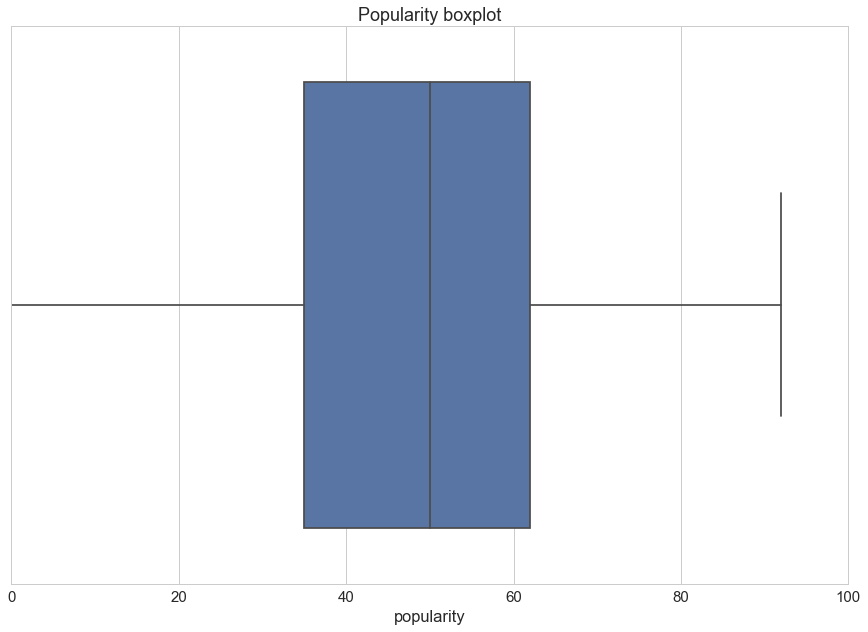

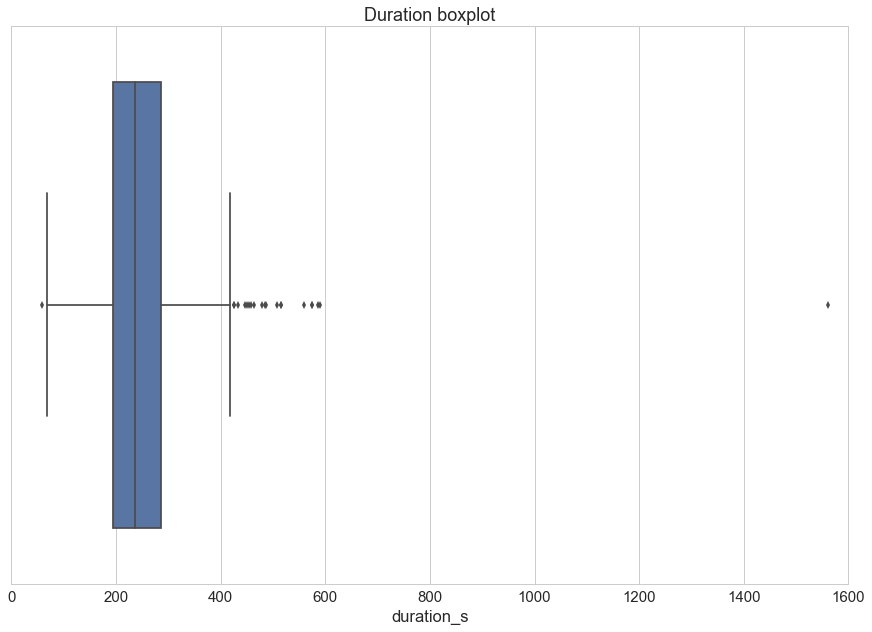

In [116]:
import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['popularity']).set_title('Popularity boxplot')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['duration_s']).set_title('Duration boxplot')

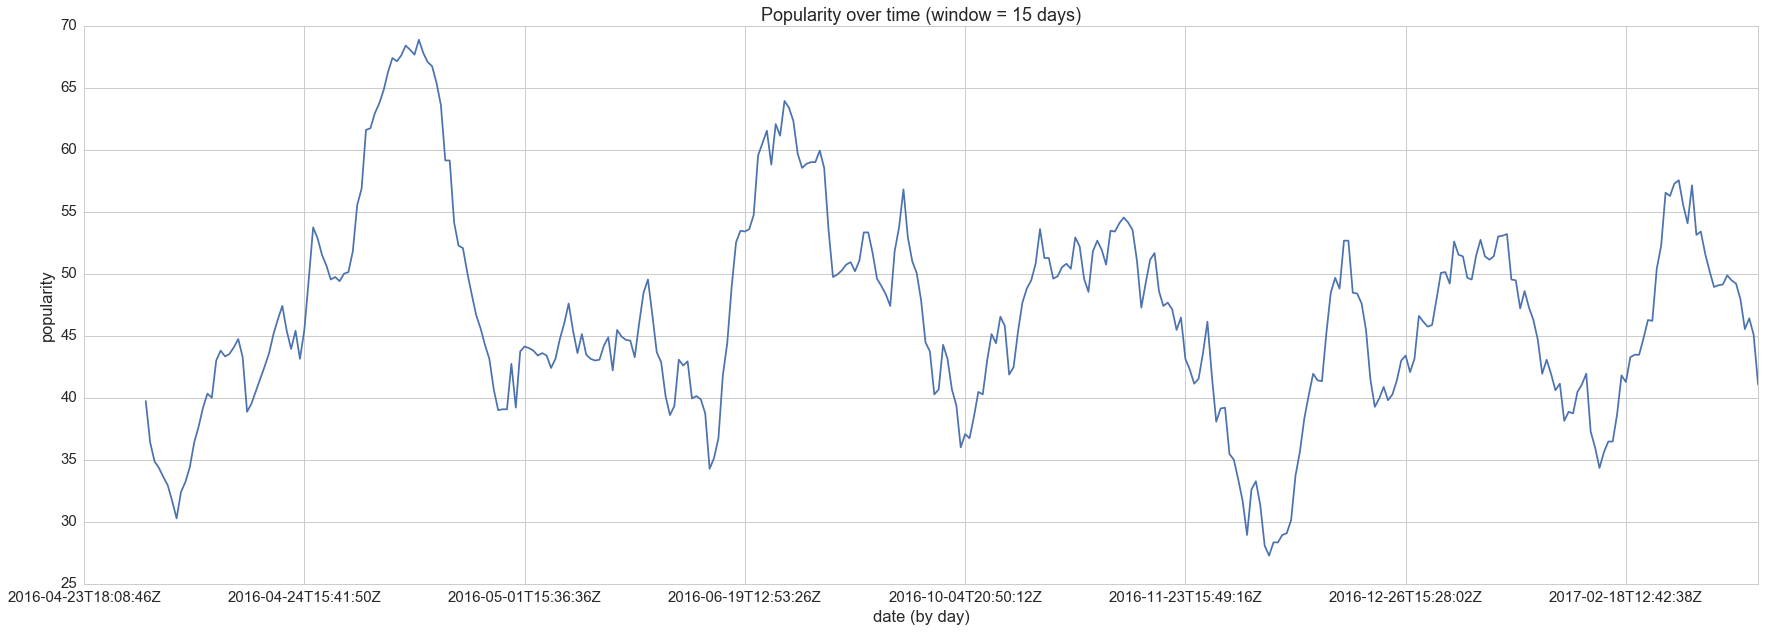

In [121]:
popularity_daily_series = pd.Series(data=np.array(tracks_df['popularity']), 
                                  name='popularity', 
                                  index=tracks_df['added_at']).sort_index()

(popularity_daily_series.rolling(window = 15)
 .mean()
 .plot(figsize=(30, 10))
 .set(xlabel='date (by day)', ylabel='popularity', title='Popularity over time (window = 15 days)'))

sns.plt.show()

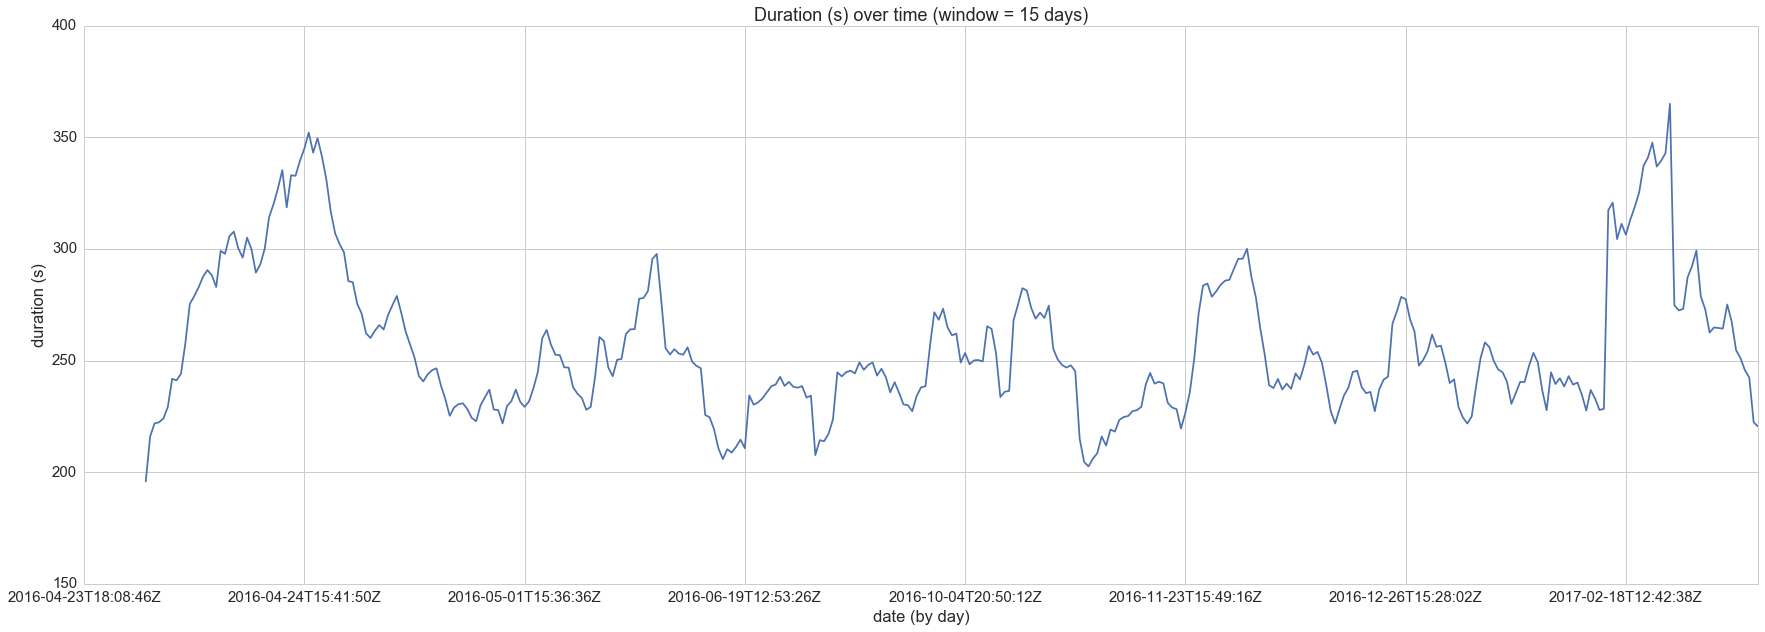

In [122]:
duration_daily_series = pd.Series(data=np.array(tracks_df['duration_s']), 
                                  name='duration_s', 
                                  index=tracks_df['added_at']).sort_index()

(duration_daily_series.rolling(window = 15)
 .mean()
 .plot(figsize=(30, 10))
 .set(xlabel='date (by day)', ylabel='duration (s)', title='Duration (s) over time (window = 15 days)'))

sns.plt.show()